In [66]:
from __future__ import annotations

import re

import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorbarbarich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [3]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [4]:
def preprocess_text(_text: str) -> str:
    """
    Приводит строку к нижнему регистру и заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел
    """
    pattern = re.compile(r'[^a-zA-Z,.?!]')
    _text = _text.lower()
    _text = re.sub(pattern, ' ', _text)
    return _text


preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [5]:
def get_binary_coded_arr(words: list[str], _word_bag: list[str]) -> list[int]:
    """
    Возвращает массив из 0 или 1

    :param words: слова из предложения
    :param _word_bag: общий набор всех слов
    :return: список из 0 и 1
    """

    return [(word in _word_bag) * 1 for word in words]


word_bag = list(set(preprocess_text(text).split()))
sentence_1 = get_binary_coded_arr(text.split('.')[0], word_bag)

print(word_bag)
print(sentence_1)

['select', 'only', 'stable', 'note', 'that', 'the', 'and', 'your', 'for', 'currently', 'of', 'install', 'command.', 'is', 'libtorch', 'most', 'tested', 'preferences', 'pytorch.', 'run', 'represents', 'version', 'c', 'supported', 'available']
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [6]:
# 1
surnames = pd.read_csv('data/surnames.csv')
surnames.head(2)

,surname,nationality
0,Woodford,English
1,Coté,French


In [7]:
# 2
nationalities = surnames.nationality.unique()
nationality_to_idx = dict(zip(nationalities, range(len(nationalities))))
idx_to_nationalities = {v: u for u, v in nationality_to_idx.items()}

In [8]:
# 3
surnames_train, surnames_test = train_test_split(surnames, test_size=0.2)

In [9]:
# 4
class Vocab:
    """
    Этот класс будет хранить все возможные буквы (символы) из фамилий
    """

    def __init__(self, data: pd.DataFrame):
        data = data[['surname']].drop_duplicates()  # оставляем уникальные фамилии

        letters = data.surname.str.lower().str.split('').apply(lambda x: x[1:-1])  # разбиваем фамилии по буквам
        letters = set(letters.sum())  # находим все буквы

        self.idx_to_token = dict(zip(range(1, len(letters) + 1), letters))  # id - буква
        self.idx_to_token[0] = ''

        self.token_to_idx = dict(zip(letters, range(1, len(letters) + 1)))  # буква - id
        self.token_to_idx[''] = 0

        self.vocab_len = len(self.idx_to_token)


vocab = Vocab(surnames)
vocab.vocab_len, vocab.token_to_idx['z'], vocab.idx_to_token[1]

(56, 29, "'")

In [10]:
MAX_SURNAME_LEN = surnames.surname.str.len().max()
MAX_SURNAME_LEN

17

In [23]:
# 5
class SurnamesDataset(Dataset):
    def __init__(self, x, y, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, surname: str):
        """ Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2) """
        output_vector = [0 for _ in range(MAX_SURNAME_LEN)]
        surname = surname.lower()
        for k in range(len(surname)):
            output_vector[MAX_SURNAME_LEN - len(surname) + k] = self.vocab.token_to_idx[surname[k]]

        return torch.FloatTensor(output_vector)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.vectorize(self.x.iloc[idx]).long(), torch.tensor(nationality_to_idx[self.y.iloc[idx]])


In [24]:
dataset_testing = SurnamesDataset(surnames.surname, surnames.nationality, Vocab(surnames))

print(dataset_testing.vectorize('Woodford')[-10:])

print(len(dataset_testing), dataset_testing.vocab.vocab_len)
print(dataset_testing[1][0], dataset_testing[1][1], dataset_testing.x.iloc[1])

tensor([ 0.,  0., 39., 45., 45., 24., 54., 45.,  7., 24.])
10980 56
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50, 45, 12, 44]) tensor(1) Coté


In [25]:
vocab_train_dataset = SurnamesDataset(surnames_train.surname, surnames_train.nationality, Vocab(surnames))
vocab_test_dataset = SurnamesDataset(surnames_test.surname, surnames_test.nationality, Vocab(surnames))

kernels = [MAX_SURNAME_LEN, 32, 32, 64, 64]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(2))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.vocab_len, 128),
    convs,
    torch.nn.Dropout(0.5),
    torch.nn.Flatten(),
    torch.nn.Linear(384, 512),
    torch.nn.Dropout(0.5),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(512, len(nationality_to_idx))
)

model(next(iter(DataLoader(vocab_train_dataset)))[0]).shape

torch.Size([1, 18])

In [27]:
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(10):
    epoch_loss = 0
    epoch_loss_val = 0

    j, k = 1, 1  # Делители running losses

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(vocab_train_dataset, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(vocab_test_dataset, batch_size=64), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(model.state_dict(), 'models/surname_model.pt')

    if i % 5 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

model.load_state_dict(torch.load('models/surname_model.pt'))

EPOCH:   1 	 LOSS: 1.6220 	 VAL LOSS: 1.3925
EPOCH:   6 	 LOSS: 1.0315 	 VAL LOSS: 1.0433
EPOCH:  11 	 LOSS: 0.8726 	 VAL LOSS: 0.9364
EPOCH:  16 	 LOSS: 0.7689 	 VAL LOSS: 0.8893
EPOCH:  21 	 LOSS: 0.6882 	 VAL LOSS: 0.9400
EPOCH:  26 	 LOSS: 0.6245 	 VAL LOSS: 0.9304
EPOCH:  31 	 LOSS: 0.5588 	 VAL LOSS: 0.9430
EPOCH:  36 	 LOSS: 0.5099 	 VAL LOSS: 1.0124


<All keys matched successfully>

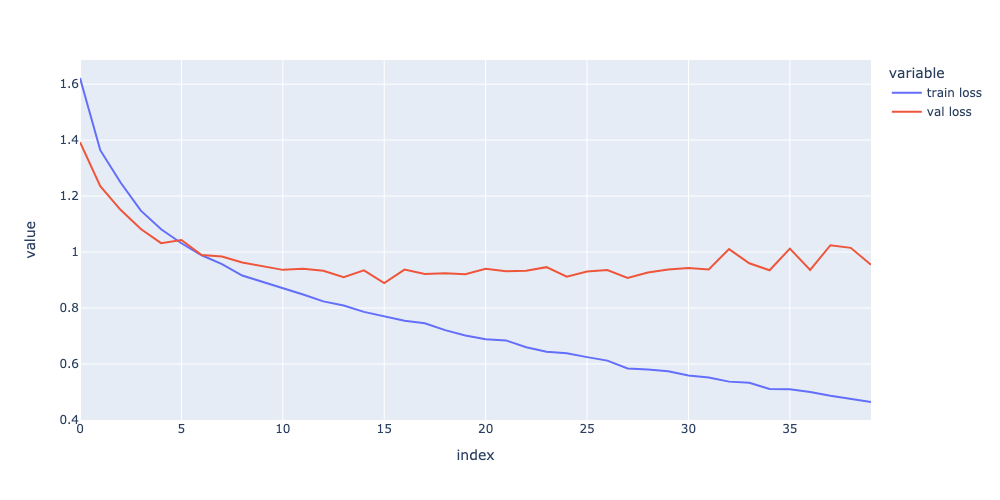

In [28]:
px.line(pd.DataFrame({'train loss': loss_log, 'val loss': loss_log_val})).show(renderer='png', width=1000)

In [29]:
model.eval()
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_train_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TRAIN ACCURACY: {right_answers / len(vocab_train_dataset):0.4f}')

TRAIN ACCURACY: 0.8931


In [30]:
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(vocab_test_dataset):0.4f}')

TEST ACCURACY: 0.7295


In [31]:
nationalities_tests = [idx_to_nationalities[int(dataset_testing[i][1])] for i in range(len(dataset_testing))]

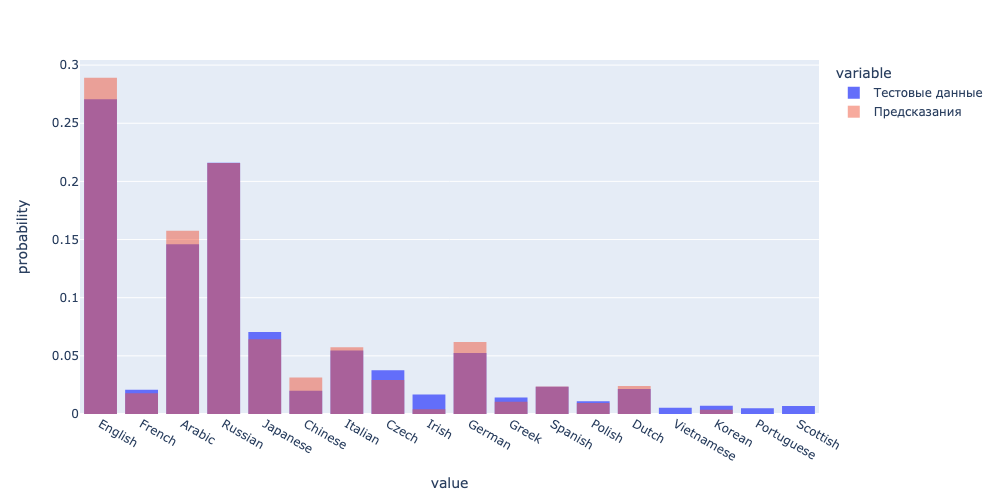

In [32]:
fig = px.histogram(pd.Series(nationalities_tests, name='Тестовые данные'), histnorm='probability')
fig.add_histogram(x=answers, histnorm='probability', opacity=0.5, name='Предсказания')
fig.update_layout(barmode='overlay')
fig.show(renderer='png', width=1000)

In [33]:
def tokenize_surname(surname: str) -> torch.LongTensor:
    """
    Токенизирует фамилию

    :param surname: фамилия строкой
    :return:
    """
    dataset = SurnamesDataset(None, None, vocab)
    return dataset.vectorize(surname).reshape(1, MAX_SURNAME_LEN).long()

In [21]:
tokenize_surname('barbarich')

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0, 25, 23,  7, 25, 23,  7, 55, 50, 38]])

In [35]:
our_surnames = {
    'Barbarich': 'Russian',
    'Akhmad': 'Arabic',
    'Tsoi': 'Korean',
    'Arakelyan': 'Russian',
    'Plastinina': 'Russian',
    'Frolov': 'Russian',
    'Geraskina': 'Russian',
    'Phan': 'Vietnamese'
}

for surname, nationality in our_surnames.items():
    model_nat = idx_to_nationalities[int(model(tokenize_surname(surname)).argmax(dim=1))]
    if model_nat == nationality:
        flag = '+'
    else:
        flag = '-'

    print(f'{flag} {surname.capitalize():>10} \t REAL: {nationality:>10} \t MODEL: {model_nat}')


+  Barbarich 	 REAL:    Russian 	 MODEL: Russian
-     Akhmad 	 REAL:     Arabic 	 MODEL: English
+       Tsoi 	 REAL:     Korean 	 MODEL: Korean
+  Arakelyan 	 REAL:    Russian 	 MODEL: Russian
- Plastinina 	 REAL:    Russian 	 MODEL: Italian
+     Frolov 	 REAL:    Russian 	 MODEL: Russian
-  Geraskina 	 REAL:    Russian 	 MODEL: Spanish
-       Phan 	 REAL: Vietnamese 	 MODEL: Chinese


In [212]:
idx_to_nationalities[int(model(tokenize_surname('dutskaya')).argmax(dim=1))]

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [232]:
# 3.1

reviews_tr = pd.read_csv('data/raw_train.csv', names=['rating', 'review']).sample(frac=0.1, random_state=21)
reviews_tr.head()

,rating,review
402762,2,Stopped into eat while attending the 2011 iron...
68324,1,"Worst.\n\nTwice we called for a Yellow Cab, on..."
498872,1,Raw wings. Yummmm. When we reported it to the ...
528042,2,We were provided samples of several flavors of...
302874,1,This doesn't even warrant the time to write a ...


In [233]:
reviews_tr.rating.value_counts()

2    28119
1    27881
Name: rating, dtype: int64

In [234]:
# 3.2

reviews_tr = reviews_tr.reset_index(drop=True)
reviews_tr.rating -= 1
reviews_tr.review = reviews_tr.review.apply(preprocess_text)
reviews_tr.head()

,rating,review
0,1,stopped into eat while attending the iron...
1,0,"worst. n ntwice we called for a yellow cab, on..."
2,0,raw wings. yummmm. when we reported it to the ...
3,1,we were provided samples of several flavors of...
4,0,this doesn t even warrant the time to write a ...


In [235]:
# 3.3

rev_train, rev_valid = train_test_split(reviews_tr, test_size=0.2)

In [223]:
# 3.4

wnl = WordNetLemmatizer()


class Vocab:
    def __init__(self, data: pd.Series):
        _word_bag = set()
        for sent in tqdm(data.review):
            sent = set(map(wnl.lemmatize, word_tokenize(sent)))
            _word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(_word_bag) + 1), _word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)


vocab_review = Vocab(reviews_tr)

100%|██████████| 56000/56000 [00:46<00:00, 1210.29it/s]


In [224]:
vocab_review.vocab_len, vocab_review.idx_to_token[1]

(66520, 'orgasmic')

In [236]:
# 3.5
class ReviewDataset(Dataset):
    def __init__(self, x: pd.Series, y: pd.Series, _vocab: Vocab):
        self.x: np.ndarray = x.values
        self.y: np.ndarray = y.values
        self.vocab = _vocab

    def vectorize(self, review: str):
        """ Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2) """

        output_tensor = torch.zeros(1, self.vocab.vocab_len)
        for word in word_tokenize(review):
            word = wnl.lemmatize(word)

            if word in vocab.token_to_idx:
                output_tensor[0, vocab.token_to_idx[word]] = 1

        return output_tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.vectorize(self.x[idx])
        return x, torch.tensor(self.y[idx]).long()

In [237]:
test = ReviewDataset(rev_valid.review, rev_valid.rating, vocab_review)
test[1]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor(1))

In [238]:
# 3.6

kernels = [1, 32, 32, 64, 64, 128, 128] # , 256, 256]
convs = torch.nn.Sequential()
for i in range(len(kernels) - 1):
    convs.add_module(f'conv {i}', torch.nn.Conv1d(kernels[i], kernels[i + 1], 3))
    convs.add_module(f'pooling {i}', torch.nn.MaxPool1d(3))
    convs.add_module(f'func {i}', torch.nn.LeakyReLU(0.1))

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(66520, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 2)
)

model(next(iter(DataLoader(test, batch_size=2)))[0])

tensor([[ 0.0111, -0.0239],
        [ 0.0107, -0.0245]], grad_fn=<AddmmBackward0>)

In [239]:
review_train_ds = ReviewDataset(rev_train.review, rev_train.rating, vocab_review)
review_valid_ds = ReviewDataset(rev_valid.review, rev_valid.rating, vocab_review)

In [240]:
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(50):
    epoch_loss = 0
    epoch_loss_val = 0
    j, k = 1, 1  # Делители running losses

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(review_train_ds, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(review_valid_ds, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(model.state_dict(), 'models/surname_model.pt')

    if i % 1 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

model.load_state_dict(torch.load('models/surname_model.pt'))

EPOCH:   1 	 LOSS: 0.6710 	 VAL LOSS: 0.6701
EPOCH:   2 	 LOSS: 0.6689 	 VAL LOSS: 0.6673
EPOCH:   3 	 LOSS: 0.6691 	 VAL LOSS: 0.6672


KeyboardInterrupt: 

In [ ]:
model(next(iter(DataLoader(test, batch_size=2)))[0])
